In [ ]:
# A) Remove packages you don't need (they cause the sklearn/transformers warnings)
%pip uninstall -y umap-learn sentence-transformers transformers

# B) Delete the corrupt dist-info folders (~ltk, ~andas)
import glob, os, shutil, site
site_dir = next(p for p in site.getsitepackages() if p.endswith("dist-packages"))
print("Cleaning in:", site_dir)
for pattern in ("*~ltk*", "*~andas*"):
    for p in glob.glob(os.path.join(site_dir, pattern)):
        print("Removing:", p)
        shutil.rmtree(p, ignore_errors=True)

# C) Re-pin the core stack for stability
%pip install --quiet \
  numpy==1.26.4 \
  pandas==2.2.2 \
  scikit-learn==1.5.2 \
  xgboost==1.7.6 \
  wordcloud==1.9.3 \
  matplotlib==3.8.4 \
  seaborn==0.13.2 \
  nltk==3.8.1

Found existing installation: umap-learn 0.5.9.post2
Uninstalling umap-learn-0.5.9.post2:
  Successfully uninstalled umap-learn-0.5.9.post2
Found existing installation: sentence-transformers 5.1.0
Uninstalling sentence-transformers-5.1.0:
  Successfully uninstalled sentence-transformers-5.1.0
Found existing installation: transformers 4.55.1
Uninstalling transformers-4.55.1:
  Successfully uninstalled transformers-4.55.1
Cleaning in: /usr/local/lib/python3.11/dist-packages
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.3/548.3 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


ImportError: cannot import name '_add_to_diagonal' from 'sklearn.utils._array_api' (/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py)

In [ ]:
# Minimal, compatible stack for TF-IDF + Logistic Regression
%pip install -q --upgrade pip
%pip install -q numpy==2.0.2 pandas==2.2.2 scikit-learn==1.5.2 matplotlib==3.8.4 seaborn==0.13.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.17.0 requires transformers, which is not installed.


In [ ]:
import numpy, sklearn, pandas, matplotlib
print("numpy", numpy.__version__)
print("sklearn", sklearn.__version__)
print("pandas", pandas.__version__)
print("matplotlib", matplotlib.__version__)


numpy 1.26.4
sklearn 1.5.2
pandas 2.2.2
matplotlib 3.8.4


In [ ]:
%pip install wordcloud

In [ ]:
# Cell U: Upload file and read into `data`
from google.colab import files
import io, pandas as pd, os

uploaded = files.upload()  # choose your amazon_alexa.tsv or .csv
if not uploaded:
    raise RuntimeError("No file selected")

fname = next(iter(uploaded))
ext = os.path.splitext(fname)[1].lower()

# auto-detect separator
sep = '\t' if ext == '.tsv' else ','
data = pd.read_csv(io.BytesIO(uploaded[fname]), sep=sep)

print("Loaded:", fname)
print("Shape:", data.shape)
print("Columns:", list(data.columns))


Saving amazon_alexa.tsv to amazon_alexa.tsv
Loaded: amazon_alexa.tsv
Shape: (3150, 5)
Columns: ['rating', 'date', 'variation', 'verified_reviews', 'feedback']


In [ ]:
# Cell A (no loader): light clean + split using existing `data`

import re, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Detect columns
TEXT_COLS  = ['Sentence','verified_reviews','review','text','reviews','content']
LABEL_COLS = ['feedback','sentiment','label','target','Rating','rating','polarity']

TEXT_COL  = next((c for c in TEXT_COLS  if c in data.columns), None)
LABEL_COL = next((c for c in LABEL_COLS if c in data.columns), None)
if not TEXT_COL:
    raise ValueError(f"Text column not found. Expected one of: {TEXT_COLS}. Found: {data.columns.tolist()}")
if not LABEL_COL:
    raise ValueError(f"Label column not found. Expected one of: {LABEL_COLS}. Found: {data.columns.tolist()}")

print("Using columns → text:", TEXT_COL, "| label:", LABEL_COL)

# Light clean
STOPWORDS = set(ENGLISH_STOP_WORDS)
def clean_text(s: str) -> str:
    s = "" if pd.isna(s) else str(s)
    s = re.sub(r"[^a-zA-Z']", " ", s).lower()
    toks = [t for t in s.split() if t not in STOPWORDS]
    return " ".join(toks)

data[TEXT_COL] = data[TEXT_COL].astype(str).map(clean_text)

# Normalize labels to {0,1}
y = data[LABEL_COL]
if y.dtype == 'O':
    y_lower = y.astype(str).str.lower()
    yes_pos = {'positive','pos','1','true','yes','y'}
    no_neg  = {'negative','neg','0','false','no','n'}
    if set(y_lower.unique()) <= (yes_pos | no_neg):
        y = y_lower.map(lambda v: 1 if v in yes_pos else 0).astype(int)
    else:
        y_num = pd.to_numeric(y, errors='coerce')
        if y_num.isna().any():
            raise ValueError("Could not infer label mapping. Convert label column to 0/1 or numeric ratings.")
        y = (y_num >= 4).astype(int)
else:
    if set(pd.unique(y)) - {0,1}:
        y = (y >= 4).astype(int)

X_text = data[TEXT_COL]
print("Label balance (pos rate):", float(y.mean()))

# Split
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train size: {len(X_train_text)}, Test size: {len(X_test_text)}")
print("Class balance (train/test):", float(y_train.mean()), float(y_test.mean()))



Using columns → text: verified_reviews | label: feedback
Label balance (pos rate): 0.9184126984126985
Train size: 2520, Test size: 630
Class balance (train/test): 0.9182539682539682 0.919047619047619


In [ ]:
# --- Cell B (fixed): Train + evaluate + save pickles ---
# --- Cell B (fixed): Train + evaluate + save pickles ---

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import FunctionTransformer
import os, pickle, matplotlib.pyplot as plt

# 1) Build & train
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1,2),      # unigrams + bigrams (learns "don't like", "not good")
        min_df=2,
        max_df=0.9,
        sublinear_tf=True
    )),
    ('clf',   LogisticRegression(
        C=2.0,
        class_weight='balanced',
        max_iter=400,
        solver='liblinear',
        random_state=42
    )),
])

pipe.fit(X_train_text, y_train)

# 2) Quick evaluation
proba = pipe.predict_proba(X_test_text)[:, 1]
pred  = (proba >= 0.5).astype(int)
print("\nClassification report @ 0.50 threshold:")
print(classification_report(y_test, pred, digits=3, target_names=['Negative','Positive']))
try:
    print("ROC-AUC:", roc_auc_score(y_test, proba))
except Exception:
    pass

# 3) Save artifacts with SAME filenames your app expects
cv = pipe.named_steps['tfidf']  # TfidfVectorizer

# ✅ Picklable identity transformer (no lambda!)
# func=None means identity in sklearn; set accept_sparse=True so .transform works on sparse matrices.
scaler = FunctionTransformer(func=None, accept_sparse=True).fit(cv.transform(X_train_text))

predictor = pipe.named_steps['clf']  # LogisticRegression (we keep filename model_xgb.pkl for app compatibility)

os.makedirs('Models', exist_ok=True)
with open('Models/countVectorizer.pkl', 'wb') as f:
    pickle.dump(cv, f)
with open('Models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('Models/model_xgb.pkl', 'wb') as f:
    pickle.dump(predictor, f)

print("\nSaved:")
print(" - Models/countVectorizer.pkl  (TF-IDF vectorizer)")
print(" - Models/scaler.pkl           (identity transformer)")
print(" - Models/model_xgb.pkl        (LogisticRegression model)")



Classification report @ 0.50 threshold:
              precision    recall  f1-score   support

    Negative      0.525     0.627     0.571        51
    Positive      0.967     0.950     0.958       579

    accuracy                          0.924       630
   macro avg      0.746     0.789     0.765       630
weighted avg      0.931     0.924     0.927       630

ROC-AUC: 0.9337769650174406

Saved:
 - Models/countVectorizer.pkl  (TF-IDF vectorizer)
 - Models/scaler.pkl           (identity transformer)
 - Models/model_xgb.pkl        (LogisticRegression model)


In [ ]:
from google.colab import files
files.download('Models/countVectorizer.pkl')
files.download('Models/scaler.pkl')
files.download('Models/model_xgb.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
data = pd.read_csv(r"amazon_alexa.tsv", delimiter = '\t', quoting = 3)

print(f"Dataset shape : {data.shape}")

Dataset shape : (3150, 5)


In [ ]:
data.head(10)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1
5,5,31-Jul-18,Heather Gray Fabric,"""I received the echo as a gift. I needed anoth...",1
6,3,31-Jul-18,Sandstone Fabric,"""Without having a cellphone, I cannot use many...",1
7,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1
8,5,30-Jul-18,Heather Gray Fabric,looks great,1
9,5,30-Jul-18,Heather Gray Fabric,"""Love it! I’ve listened to songs I haven’t hea...",1


In [ ]:
#Column names

print(f"Feature names : {data.columns.values}")

Feature names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [ ]:
#Getting the record where 'verified_reviews' is null

data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [ ]:
#We will drop the null record

data.dropna(inplace=True)

In [ ]:
print(f"Dataset shape after dropping null values : {data.shape}")

Dataset shape after dropping null values : (3149, 5)


In [ ]:
#Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column

data['length'] = data['verified_reviews'].apply(len)

In [ ]:
data.head(10)

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5
5,5,31-Jul-18,Heather Gray Fabric,"""I received the echo as a gift. I needed anoth...",1,174
6,3,31-Jul-18,Sandstone Fabric,"""Without having a cellphone, I cannot use many...",1,367
7,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1,221
8,5,30-Jul-18,Heather Gray Fabric,looks great,1,11
9,5,30-Jul-18,Heather Gray Fabric,"""Love it! I’ve listened to songs I haven’t hea...",1,116


In [ ]:
#Randomly checking for 15th record

print(f"'verified_reviews' column value: {data.iloc[10]['verified_reviews']}") #Original value
print(f"Length of review : {len(data.iloc[15]['verified_reviews'])}") #Length of review using len()
print(f"'length' column value : {data.iloc[15]['length']}") #Value of the column 'length'

'verified_reviews' column value: "I sent it to my 85 year old Dad, and he talks to it constantly."
Length of review : 27
'length' column value : 27


In [ ]:
data.dtypes

,0
rating,int64
date,object
variation,object
verified_reviews,object
feedback,int64
length,int64


Now Analyzing Column 'rating'

In [ ]:
len(data)
#Distinct values of 'rating' and its count

print(f"Rating value count: \n{data['rating'].value_counts()}")

Rating value count: 
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


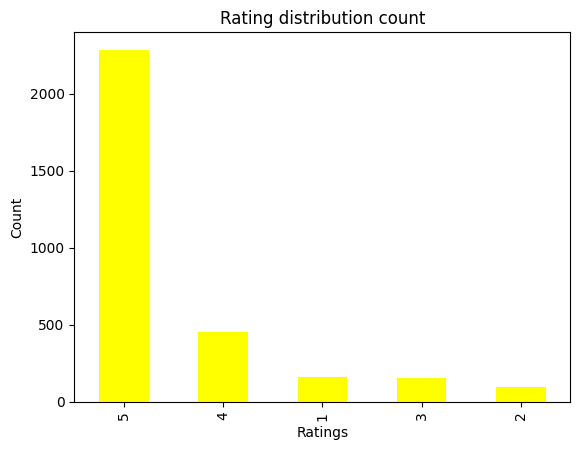

In [ ]:
#Bar plot to visualize the total counts of each rating

data['rating'].value_counts().plot.bar(color = 'yellow')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [ ]:
#Finding the percentage distribution of each rating - we'll divide the number of records for each rating by total number of records

print(f"Rating value count - percentage distribution: \n{round(data['rating'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution: 
rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64


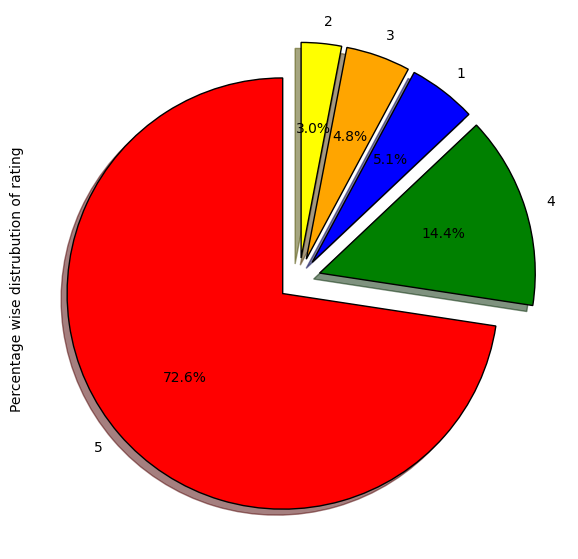

In [ ]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['rating'].value_counts()/data.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

Now Analyzing column 'feedback'

In [ ]:
#Distinct values of 'feedback' and its count

print(f"Feedback value count: \n{data['feedback'].value_counts()}")

Feedback value count: 
feedback
1    2893
0     256
Name: count, dtype: int64


In [ ]:
#Extracting the 'verified_reviews' value for one record with feedback = 0

review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [ ]:
#Extracting the 'verified_reviews' value for one record with feedback = 1

review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


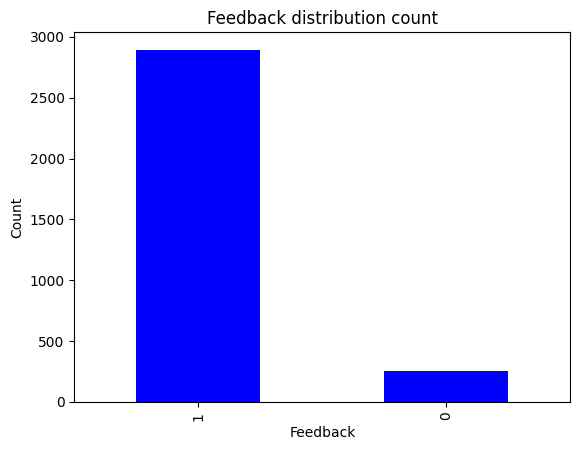

In [ ]:
#Bar graph to visualize the total counts of each feedback

data['feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [ ]:
#Finding the percentage distribution of each feedback - we'll divide the number of records for each feedback by total number of records

print(f"Feedback value count - percentage distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
feedback
1    91.87
0     8.13
Name: count, dtype: float64


<Axes: ylabel='Percentage wise distrubution of feedback'>

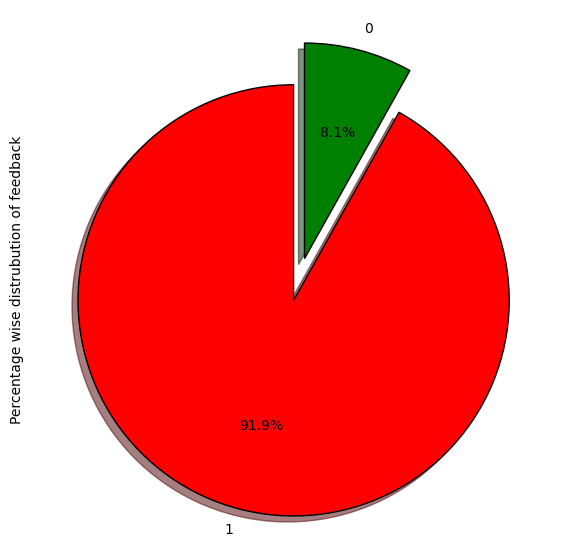

In [ ]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['feedback'].value_counts()/data.shape[0]

explode=(0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')

In [ ]:
#Feedback = 0
data[data['feedback'] == 0]['rating'].value_counts()

,count
rating,
1,161
2,95


In [ ]:
#Feedback = 1
data[data['feedback'] == 1]['rating'].value_counts()

,count
rating,
5,2286
4,455
3,152


Now Analyzing column 'variation'

In [ ]:
#Distinct values of 'variation' and its count

print(f"Variation value count: \n{data['variation'].value_counts()}")

Variation value count: 
variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


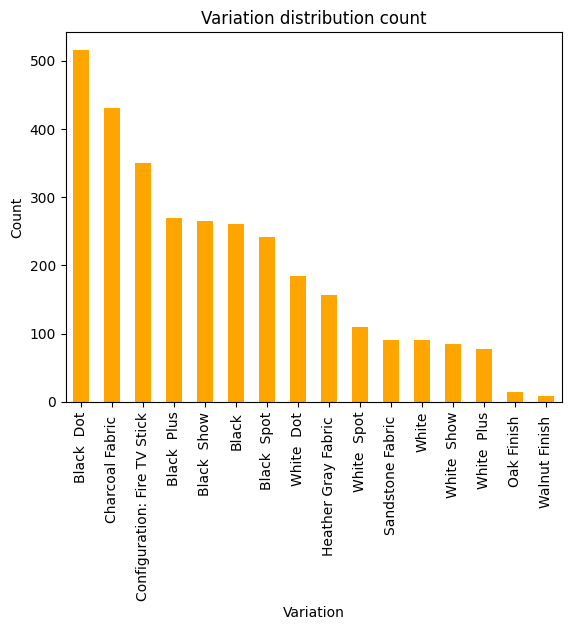

In [ ]:
#Bar graph to visualize the total counts of each variation

data['variation'].value_counts().plot.bar(color = 'orange')
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()


In [ ]:
#Finding the percentage distribution of each variation - we'll divide the number of records for each variation by total number of records

print(f"Variation value count - percentage distribution: \n{round(data['variation'].value_counts()/data.shape[0]*100,2)}")

Variation value count - percentage distribution: 
variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64


In [ ]:
data.groupby('variation')['rating'].mean()

,rating
variation,
Black,4.233716
Black Dot,4.453488
Black Plus,4.370370
Black Show,4.490566
Black Spot,4.311203
Charcoal Fabric,4.730233
Configuration: Fire TV Stick,4.591429
Heather Gray Fabric,4.694268
Oak Finish,4.857143


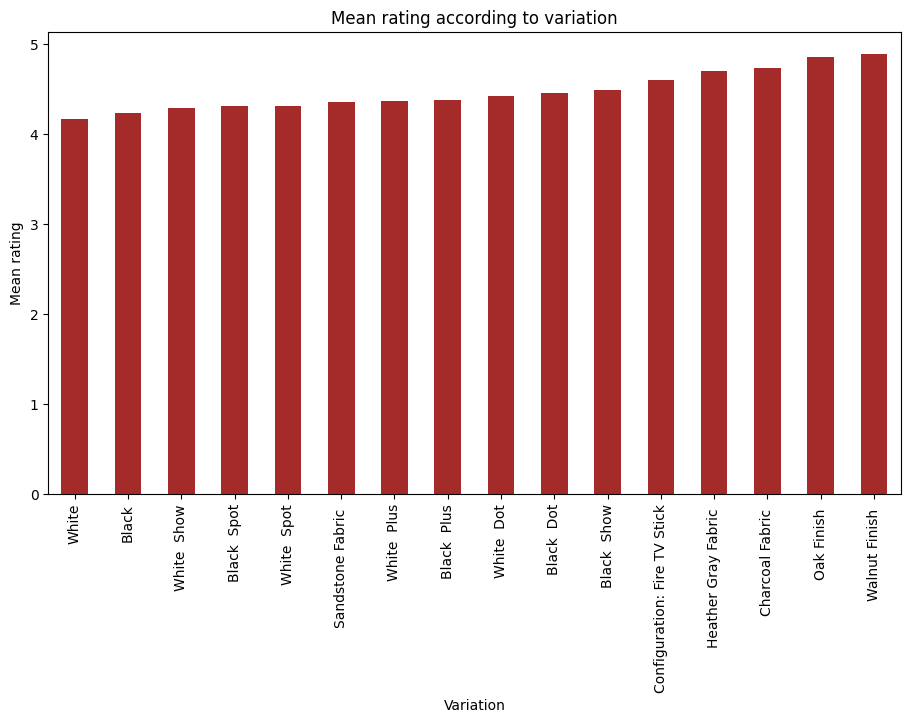

In [ ]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color = 'brown', figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

Now Analyzing column 'verified_reviews'

In [ ]:
data['length'].describe()

,length
count,3149.000000
mean,132.714513
std,182.541531
min,1.000000
25%,30.000000
50%,74.000000
75%,166.000000
max,2853.000000


[Text(0.5, 1.0, 'Distribution of length of review ')]

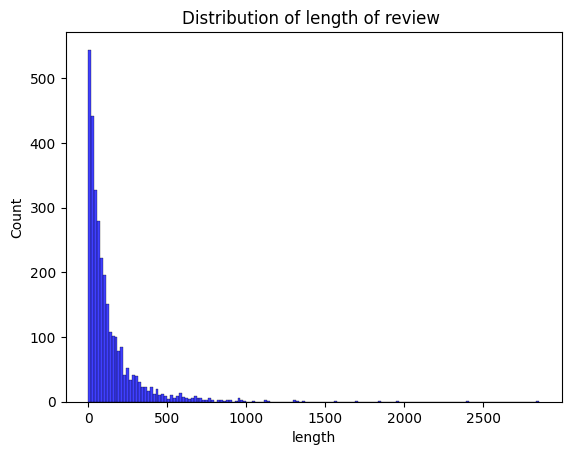

In [ ]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

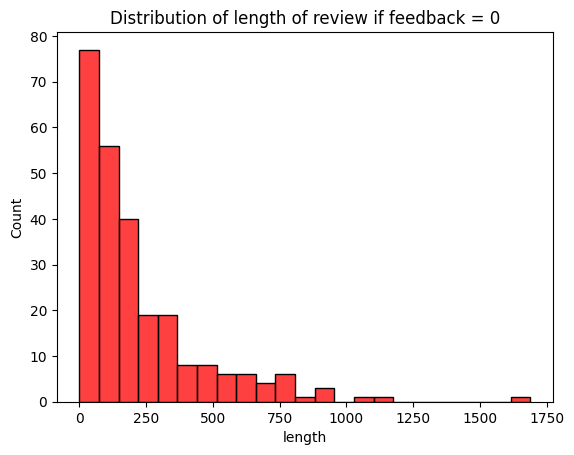

In [ ]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

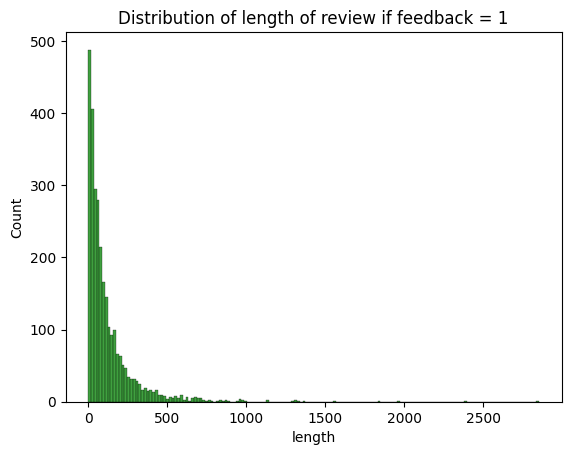

In [ ]:
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

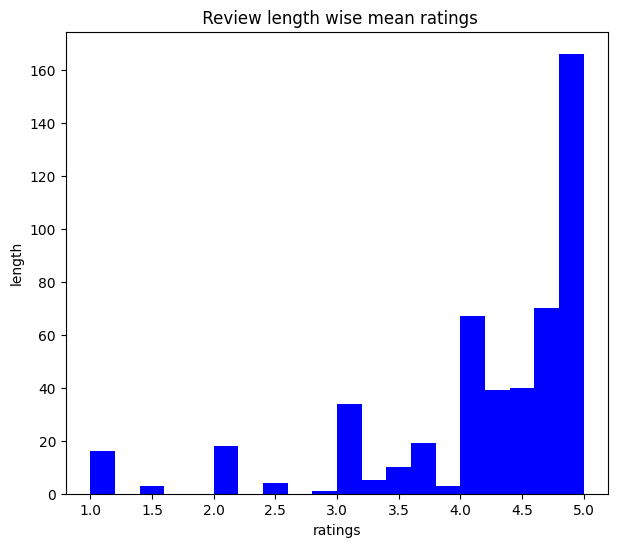

In [ ]:
data.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [ ]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

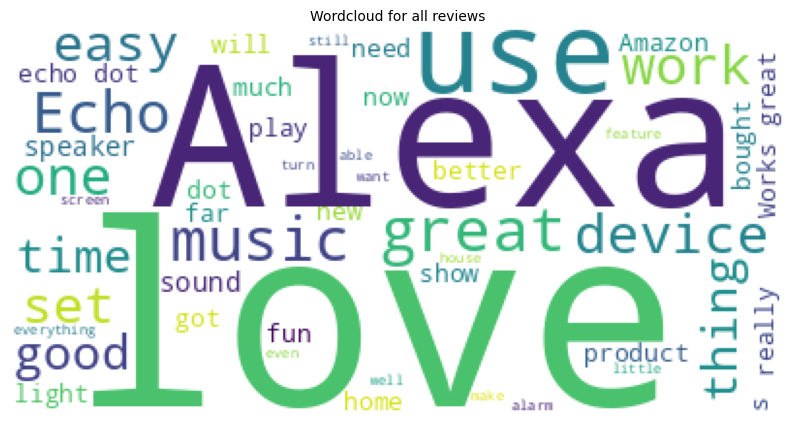

In [ ]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

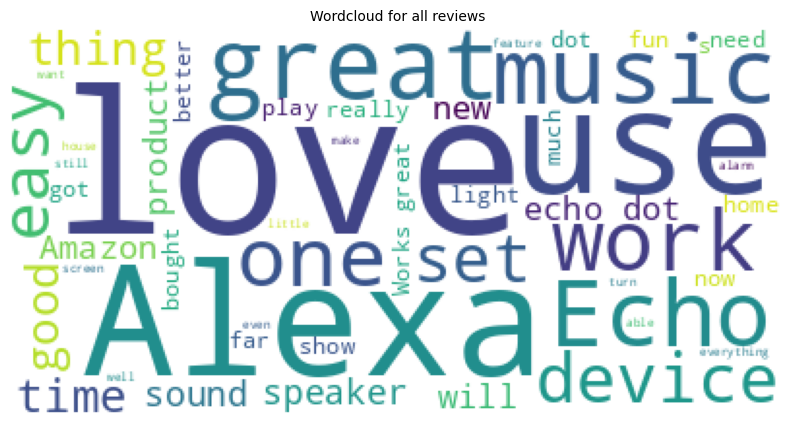

In [ ]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

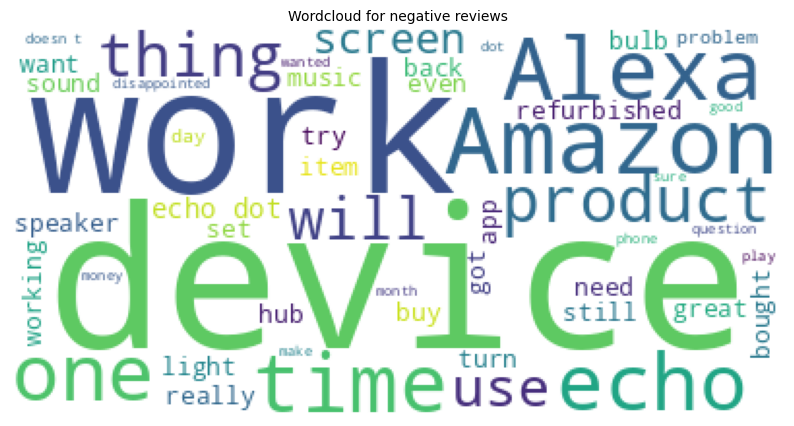

In [ ]:
# Filter for negative reviews (feedback == 0)
negative_reviews = data[data['feedback'] == 0]['verified_reviews']

# Combine negative reviews
unique_negative = " ".join([review for review in negative_reviews])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

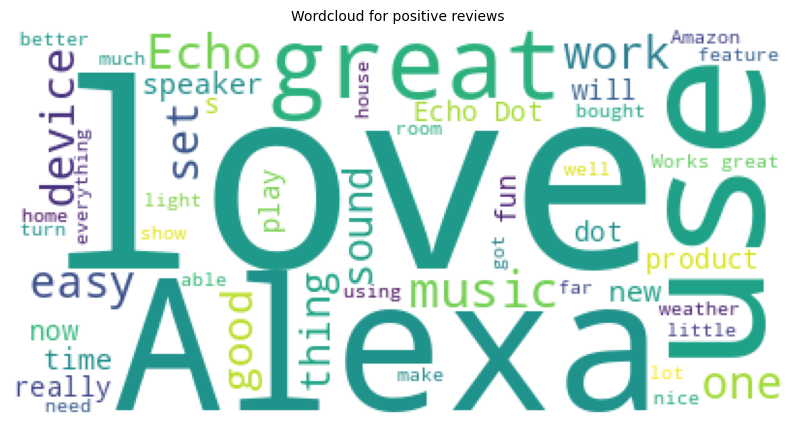

In [ ]:
# Filter for positive reviews (feedback == 1)
positive_reviews = data[data['feedback'] == 1]['verified_reviews']

# Combine positive reviews
unique_positive = " ".join([review for review in positive_reviews])

wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

Now Preprocessing and Modelling

In [ ]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

In [ ]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [ ]:
#Saving the Count Vectorizer
import os
if not os.path.exists('Models'):
    os.makedirs('Models')
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

In [ ]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3149, 2500)
y shape: (3149,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2204, 2500)
y train: (2204,)
X test: (945, 2500)
y test: (945,)


In [ ]:

print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 10


In [ ]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [ ]:
#Saving the scaler model
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

Using Random Forest

In [ ]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [ ]:
#Accuracy of the model on training and testing data

print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9945553539019963
Testing Accuracy : 0.946031746031746


In [ ]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

In [ ]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

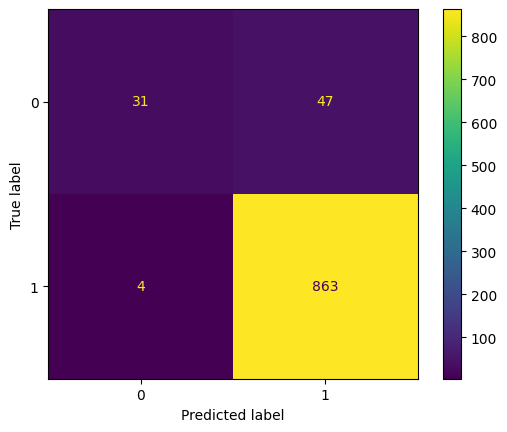

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

K fold cross-validation

In [ ]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9324002468120115
Standard Variance : 0.008193664451676252


In [ ]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [ ]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [ ]:
#Getting the best parameters from the grid search


print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 8, 'n_estimators': 100}


In [ ]:

print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 96.7899274047187
Cross validation mean accuracy on test set : 92.18466424682397
Accuracy score for test set : 0.946031746031746


XgBoost

In [ ]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
#Accuracy of the model on training and testing data

print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.9736842105263158
Testing Accuracy : 0.9407407407407408


In [ ]:
y_preds = model_xgb.predict(X_test)

In [ ]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 33  45]
 [ 14 853]]


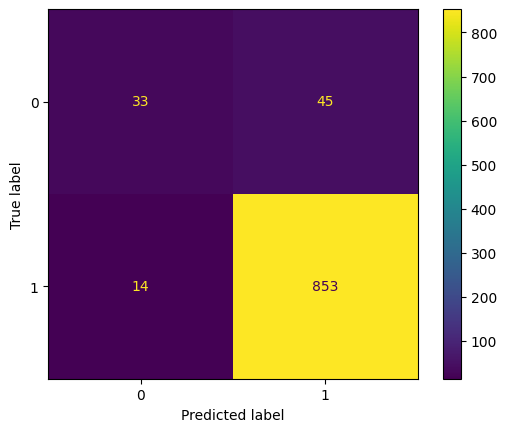

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [ ]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('Models/model_xgb.pkl', 'wb'))

Decision Tree Classifier

In [ ]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [ ]:
#Accuracy of the model on training and testing data

print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 0.9945553539019963
Testing Accuracy : 0.9185185185185185


In [ ]:
y_preds = model_dt.predict(X_test)

In [ ]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)


[[ 41  37]
 [ 96 771]]


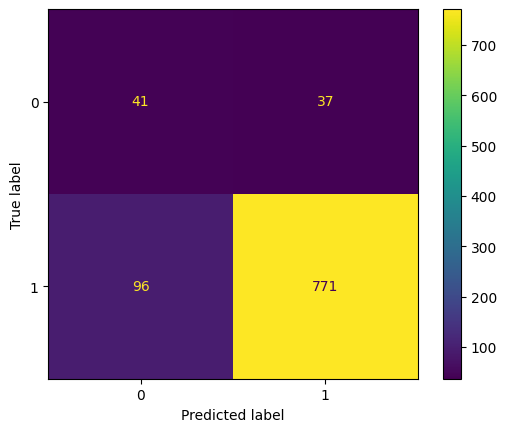

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

In [ ]:
import os, pickle
os.makedirs('Models', exist_ok=True)

with open('Models/countVectorizer.pkl', 'wb') as f:
    pickle.dump(cv, f)

with open('Models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('Models/model_xgb.pkl', 'wb') as f:
    pickle.dump(model_xgb, f)

In [ ]:
from google.colab import files
for fn in ['Models/countVectorizer.pkl', 'Models/scaler.pkl', 'Models/model_xgb.pkl']:
    files.download(fn)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>